In [ ]:
import pandas as pd
import math
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams["figure.figsize"] = (25,5)

model_sub = True  

path_df = ''
path_model = ''

if model_sub:
  path_df = ''
  path_model = ''
  
path_proximahora = ''

est = 'A806'
path_dados = ''+est+'.csv'
col = 'temp_max_(C)'  
var = 'temp'
var_title = 'Temperatura máxima (°C)'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Funcoes

''' Cria os datasets baseado no valor de n_in '''
def dataframe_to_Xy(df,n_in):
    df_np = df
    X, y = [], []
    for i in range(len(df)-n_in):
        X.append([[a] for a in df_np[i:i+n_in]])
        y.append(df_np[i+n_in])
    return np.array(X), np.array(y)

''' Converte dataframe em csv '''
def dataframe_to_csv(dataframe,path):
  dataframe['Data'] = dataframe.index
  dataframe.to_csv(path, index=False)

'''
    Formatacao dos dados que serao utilizados
    na previsao [[a,b,c],[d,e,f]] -> [[[[a],[b],[c]]],[[[d],[e],[f]]]] -> 
    format[0] = [[[a],[b],[c]]]
'''
def format_data(data):
    format = []
    for d in data:
        format.append([[[a] for a in d]])

    return format

'''
    Atualiza vetor de dados para previsao
    com base no ultimo valor previsto.
    data = [[[a],[b],[c],[d],[e]]]
    new_data = [f]
    result = [[[b],[c],[d],[e],[f]]]
'''
def new_data(data, new_data):
    
    new_array_data = []
    new_array_data_shift = []
    l1 = data[0]

    for i in range(len(l1)):
        a = l1[i]
        new_array_data.append(a[0])

    for i in range(len(new_array_data)-1):
        new_array_data_shift.append(new_array_data[i + 1])

    new_array_data_shift.append(new_data[-1])

    res = format_data([new_array_data_shift])

    return res[0]
  
''' Gera o modelo de Dois Dias'''  
def model_generator_dois_dias(df,col,lt,m):
  
  model = Sequential()

  # Normalizacao
  max_value = df[col].max()
  min_value = df[col].min()
  df[col] = (df[col]-min_value)/(max_value-min_value)
  
  # Dataset de treino e teste
  index_test = math.ceil(len(df.index)*lt)
  train_set = df[:-48]
  test_set = df[-48:]

  # Criando datasets de treino e teste de acordo com o valor de h (num. amostras para previsao)
  train_X, train_y = dataframe_to_Xy(train_set[col],m);
  test_X, test_y = dataframe_to_Xy(test_set[col],m);
  
  # Treinando modelo
  model.add(LSTM(units=64, input_shape=(m,1),activation="relu",recurrent_activation="sigmoid"))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  historico = model.fit(train_X, train_y, epochs = 3, batch_size = 1, verbose = 1)

  return train_set, test_set, min_value, max_value, model 

''' Gera o modelo de Proxima Hora'''  
def model_generator_proxima_hora(df,col,lt,m):
  
  model = Sequential()

  # Normalizacao
  max_value = df[col].max()
  min_value = df[col].min()
  df[col] = (df[col]-min_value)/(max_value-min_value)
  
  # Dataset de treino e teste
  index_test = math.ceil(len(df.index)*lt)
  train_set = df[:-index_test]
  test_set = df[-index_test:]

  # Criando datasets de treino e teste de acordo com o valor de h (num. amostras para previsao)
  train_X, train_y = dataframe_to_Xy(train_set[col],m);
  test_X, test_y = dataframe_to_Xy(test_set[col],m);
  
  # Treinando modelo
  model.add(LSTM(units=64, input_shape=(m,1),activation="relu",recurrent_activation="sigmoid"))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(train_X, train_y, epochs = 3, batch_size = 1, verbose = 1)

  return train_set, test_set, min_value, max_value, model 


''' Salva modelo '''
def model_save(train,test,min_value,max_value,model,path):
  
    try:
        model.save(path)
        dataframe_to_csv(train,path+'/train_set.csv')
        dataframe_to_csv(test,path+'/test_set.csv')
        norm_df = pd.DataFrame({'min_value': [min_value], 'max_value': [max_value]})
        dataframe_to_csv(norm_df,path+'/norm.csv')
        return 1
    except Exception as e:
        print('> Erro ao salvar modelo!')
        return 0

''' Carrega modelo '''
def load_model(path):

  try:
      model = keras.models.load_model(path)
      train_set = pd.read_csv(path+'/train_set.csv',index_col='Data',parse_dates=True,low_memory=False)
      test_set = pd.read_csv(path+'/test_set.csv',index_col='Data',parse_dates=True,low_memory=False)
      norm = pd.read_csv(path+'/norm.csv')
      min_value = norm['min_value'].values[0]
      max_value = norm['max_value'].values[0]
      return train_set, test_set, min_value, max_value, model
  except Exception as e:
     print('> Erro ao carregar modelo!')
     return 0

''' 
    Previsao Dois Dias

    col: variavel em analise
    data: dataframe completo
    n: amostras a serem previstas
    m: amostras necessarias para o modelo
    model: modelo treinado

    retorna uma lista com n amostras previstas. Para
    esta aplicacao n sera sempre igual a 12. Ou seja,
    cada modelo retornará 12 amostra, ou a previsao
    para 2 dias.
    
'''
def make_predict_dois_dias(col,data,n,m,model):
  
  # Lista de m valores reais
  train_data = data[col][-m:].values

  # Formatando dados
  r = format_data([train_data])
  data_formatted = r[0]

  forecast = []
  list_prev = []

  for j in range(n):
      if len(list_prev) == 0:
          value = model.predict(data_formatted)
          value = value[0, 0].item()
          list_prev.append(value)
      else:
          data_formatted = new_data(data_formatted,list_prev)
          value = model.predict(data_formatted)
          value = value[0, 0].item()
          list_prev.append(value)

  forecast.append(list_prev)
  
  return forecast

''' 
  Previsao Proxima Hora 

  col: variavel em analise
  data: dataframe completo
  n: amostras a serem previstas
  m: amostras necessarias para o modelo
  model: modelo treinado

'''
def make_predict_proxima_hora(col,data,n,m,model):
  
  forecast = []
  list_prev = []

  # Formatando dados
  r = format_data([data[:m]])
  data_formatted = r[0]

  
  for j in range(n):
      if len(list_prev) == 0:
          value = model.predict(data_formatted)
          value = value[0, 0].item()
          list_prev.append(value)
      else:
          data_formatted = new_data(data_formatted,[data[m+j]])
          value = model.predict(data_formatted)
          value = value[0, 0].item()
          list_prev.append(value)
          

  # Armazenando as 24 primeiras amostras
  t = data[:m]
  for i in reversed(t):
    list_prev.insert(0,i)

  forecast.append(list_prev)
  
  return forecast

''' Plot de graficos e calculo de erros'''
def plot_and_errors(forecast,real,forecast_norm,real_norm,title,ax,ay,x_label,y_label):
  plt.rcParams["figure.figsize"] = (ax,ay)

  mae = mean_absolute_error(real,forecast)
  rmse = math.sqrt(mean_squared_error(real,forecast))

  mape = np.mean(np.abs((real - forecast) / real)) * 100
  maape = np.mean(np.arctan(np.abs((real_norm - forecast_norm) / (real_norm)))) * 100

  print("Mean Absolute Error:",mae)
  print("Root Mean Square Error:",rmse)
  print("Mean Absolute Error Percentage:",mape)
  print("Mean Arctangent Absolute Percentage Error:",round(maape,3))

  plt.plot(real)
  plt.plot(forecast)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(['Dados reais','Previsão'])


In [ ]:
# Separando datasets com granularidade de 4 horas
df = pd.read_csv(path_dados,index_col='Data',parse_dates=True,low_memory=False)
df.drop(df.columns.difference([col]), 1, inplace=True)

horas1 = [0, 4, 8, 12, 16, 20]
horas2 = [1, 5, 9, 13, 17, 21]
horas3 = [2, 6, 10, 14, 18, 22]
horas4 = [3, 7, 11, 15, 19, 23]

madrugada = [0,1, 2, 3, 4, 5]
manha = [6, 7, 8, 9, 10, 11]
tarde = [12, 13, 14, 15, 16, 17]
noite = [18, 19, 20, 21, 22, 23]

df1 = pd.DataFrame(columns=[col], index=pd.to_datetime([]))
df2 = pd.DataFrame(columns=[col], index=pd.to_datetime([]))
df3 = pd.DataFrame(columns=[col], index=pd.to_datetime([]))
df4 = pd.DataFrame(columns=[col], index=pd.to_datetime([]))

for index, row in df.iterrows():
    
    row_df = pd.DataFrame([row[col]], columns=[col], index = [pd.to_datetime(index)])
    
    if model_sub:
      if index.hour in horas1:
        df1 = pd.concat([df1, row_df])  
      elif index.hour in horas2:
        df2 = pd.concat([df2, row_df])
      elif index.hour in horas3:
        df3 = pd.concat([df3, row_df])
      else:
        df4 = pd.concat([df4, row_df])
    else:
      if index.hour in madrugada:
        df1 = pd.concat([df1, row_df])  
      elif index.hour in manha:
        df2 = pd.concat([df2, row_df])
      elif index.hour in tarde:
        df3 = pd.concat([df3, row_df])
      else:
        df4 = pd.concat([df4, row_df])


dataframe_to_csv(df1,path_df+est+'_df1.csv')
dataframe_to_csv(df2,path_df+est+'_df2.csv')
dataframe_to_csv(df3,path_df+est+'_df3.csv')
dataframe_to_csv(df4,path_df+est+'_df4.csv')


In [ ]:
# Dataframes ja separados
df1 = pd.read_csv(path_df+est+'_df1.csv',index_col='Data',parse_dates=True,low_memory=False)
df2 = pd.read_csv(path_df+est+'_df2.csv',index_col='Data',parse_dates=True,low_memory=False)
df3 = pd.read_csv(path_df+est+'_df3.csv',index_col='Data',parse_dates=True,low_memory=False)
df4 = pd.read_csv(path_df+est+'_df4.csv',index_col='Data',parse_dates=True,low_memory=False)


In [ ]:
# Gerando os 4 modelos do cenario de subamostras ou periodos
lt = 0.2 # porcentagem para o dataset de teste
m = 24
train_set1, test_set1, min_value1, max_value1, model1 = model_generator_dois_dias(df1,col,lt,m)
model_save(train_set1,test_set1,min_value1,max_value1,model1,path_model+est+'_modelo1_'+var+'_'+str(m))

train_set2, test_set2, min_value2, max_value2, model2 = model_generator_dois_dias(df2,col,lt,m)
model_save(train_set2,test_set2,min_value2,max_value2,model2,path_model+est+'_modelo2_'+var+'_'+str(m))

train_set3, test_set3, min_value3, max_value3, model3 = model_generator_dois_dias(df3,col,lt,m)
model_save(train_set3,test_set3,min_value3,max_value3,model3,path_model+est+'_modelo3_'+var+'_'+str(m))

train_set4, test_set4, min_value4, max_value4, model4 = model_generator_dois_dias(df4,col,lt,m)
model_save(train_set4,test_set4,min_value4,max_value4,model4,path_model+est+'_modelo4_'+var+'_'+str(m))


In [ ]:
# Gerando modelo online 
lt = 0.2 
m = 24
df = pd.read_csv(path_dados,index_col='Data',parse_dates=True,low_memory=False)
df.drop(df.columns.difference([col]), 1, inplace=True)

train_set_online, test_set_online, min_value_online, max_value_online, model_online = model_generator_proxima_hora(df,col,lt,m)
model_save(train_set_online,test_set_online,min_value_online,max_value_online,model_online,path_proximahora+est+'_modelo_'+var+'_'+str(m))


Mean Absolute Error: 0.6748114301807789
Root Mean Square Error: 0.7837150593525528
Mean Absolute Error Percentage: 2.5108792978478665
Mean Arctangent Absolute Percentage Error: 2.929


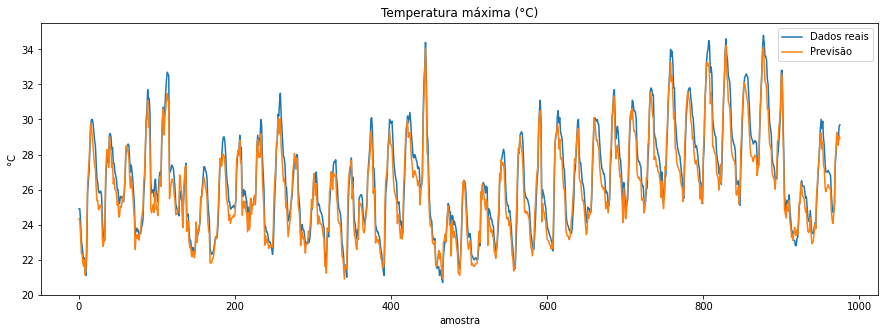

In [ ]:
# Cenario 1: Proxima Hora
m = 24 
model_online = Sequential()
train_set_online, test_set_online, min_value_online, max_value_online, model_online = load_model(path_proximahora+est+'_modelo_'+var+'_'+str(m))

n = 1000
n_prev = abs(n-m)
data = train_set_online[col].values
data = data[:n]

previsao_norm = make_predict_proxima_hora(col,data,n_prev,m,model_online)[0]
previsao = []

real_train_norm = train_set_online[:n]
real_train_norm = real_train_norm[col].values
real_train = []

for i in range(len(previsao_norm)):
  previsao.append(previsao_norm[i]*(max_value_online-min_value_online)+min_value_online)
  real_train.append(real_train_norm[i]*(max_value_online-min_value_online)+min_value_online)

title = var_title
plot_and_errors(np.array(previsao[m:]),np.array(real_train[m:]),np.array(previsao_norm[m:]),np.array(real_train_norm[m:]),title,15,5,'amostra','°C')



> 0 / 1
<class 'list'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Mean Absolute Error: 0.9947309772173559
Root Mean Square Error: 1.3239557288844506
Mean Absolute Error Percentage: 3.8693852878236132
Mean Arctangent Absolute Percentage Error: 4.696


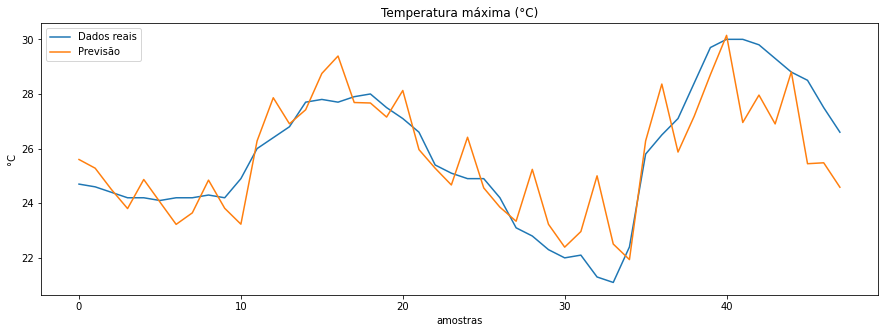

In [ ]:
# Cenario 2 e 3 simulacao
model_sub = True

if model_sub:
  path_model = '/content/drive/MyDrive/teste/modelos/subamostras/'
else:
  path_model = '/content/drive/MyDrive/teste/modelos/periodos/'

m = 24
n = 12
a = 20
model1 = Sequential()
model2 = Sequential()
model3 = Sequential()
model4 = Sequential()

train_set1, test_set1, min_value1, max_value1, model1 = load_model(path_model+est+'_modelo1_'+var+'_'+str(m))
train_set2, test_set2, min_value2, max_value2, model2 = load_model(path_model+est+'_modelo2_'+var+'_'+str(m))
train_set3, test_set3, min_value3, max_value3, model3 = load_model(path_model+est+'_modelo3_'+var+'_'+str(m))
train_set4, test_set4, min_value4, max_value4, model4 = load_model(path_model+est+'_modelo4_'+var+'_'+str(m))

previsao = []
previsao_norm = []

max = [max_value1, max_value2, max_value3, max_value4]
min = [min_value1, min_value2, min_value3, min_value4]

for k in range(a):
  clear_output(wait=True)
  print(">",k,"/",a)
  
  dia1, dia2 = [], []

  p1 = make_predict_dois_dias(col,train_set1[k*12:m+(k*12)],n,m,model1)[0]
  p2 = make_predict_dois_dias(col,train_set2[k*12:m+(k*12)],n,m,model2)[0]
  p3 = make_predict_dois_dias(col,train_set3[k*12:m+(k*12)],n,m,model3)[0]
  p4 = make_predict_dois_dias(col,train_set4[k*12:m+(k*12)],n,m,model4)[0]
  
  if model_sub:
    for i in range(len(p1)):
      previsao.append(p1[i]*(max_value1-min_value1)+min_value1)
      previsao_norm.append(p1[i])
      previsao.append(p2[i]*(max_value2-min_value2)+min_value2)
      previsao_norm.append(p2[i])
      previsao.append(p3[i]*(max_value3-min_value3)+min_value3)
      previsao_norm.append(p3[i])
      previsao.append(p4[i]*(max_value4-min_value4)+min_value4)
      previsao_norm.append(p4[i])
  else:

    dia1 = [p1[:6],p2[:6],p3[:6],p4[:6]]
    dia2 = [p1[-6:],p2[-6:],p3[-6:],p4[-6:]]
    
    for i in range(len(dia1)):
        for j in dia1[i]:
          previsao.append(j*(max[i]-min[i])+min[i])
          previsao_norm.append(j)
    
    for i in range(len(dia2)):
      for j in dia2[i]:
          previsao.append(j*(max[i]-min[i])+min[i])
          previsao_norm.append(j)


v1, v2, v3, v4 = [], [], [], []
if model_sub:
  v1 = [0, 4, 8, 12, 16, 20]
  v2 = [1, 5, 9, 13, 17, 21]
  v3 = [2, 6, 10, 14, 18, 22]
  v4 = [3, 7, 11, 15, 19, 23]
else:
  v1 = [0,1, 2, 3, 4, 5]
  v2 = [6, 7, 8, 9, 10, 11]
  v3 = [12, 13, 14, 15, 16, 17]
  v4 = [18, 19, 20, 21, 22, 23]

df = pd.read_csv(path_dados,index_col='Data',parse_dates=True,low_memory=False)
df.drop(df.columns.difference([col]), 1, inplace=True)

real_train_plot = df[col].head(a*48).values
real_train = df[col].head(a*48)
real_train = real_train.to_frame()

new_df = pd.DataFrame(columns=[col], index=pd.to_datetime([]))

for index, row in real_train.iterrows():
    
  if index.hour in v1:
    row_df = pd.DataFrame([(row[col]-min_value1)/(max_value1-min_value1)], columns=[col], index = [pd.to_datetime(index)])
    new_df = pd.concat([new_df, row_df])
  elif index.hour in v2:
    row_df = pd.DataFrame([(row[col]-min_value2)/(max_value2-min_value2)], columns=[col], index = [pd.to_datetime(index)])
    new_df = pd.concat([new_df, row_df])
  elif index.hour in v3:
    row_df = pd.DataFrame([(row[col]-min_value3)/(max_value3-min_value3)], columns=[col], index = [pd.to_datetime(index)])
    new_df = pd.concat([new_df, row_df])
  else:
    row_df = pd.DataFrame([(row[col]-min_value4)/(max_value4-min_value4)], columns=[col], index = [pd.to_datetime(index)])
    new_df = pd.concat([new_df, row_df])

new_df_norm = new_df[col].head(a*48).values

if model_sub:
  title = 'Modelo com Subamostras - '+var_title
else:
  title = 'Modelo com Períodos - '+var_title

title = var_title
plot_and_errors(previsao,real_train_plot,np.array(previsao_norm),np.array(new_df_norm),title,15,5,'amostras','°C')